# MIMIC mortality (supervised)

This notebook reproduces the supervised SUAVE mortality analysis.

In [1]:
import importlib.util
import json
import sys
from pathlib import Path
from typing import Dict, List, Mapping, Optional, Tuple
from tqdm import tqdm

from IPython.display import Markdown, display

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

EXAMPLES_DIR = Path().resolve()
if not EXAMPLES_DIR.exists():
    raise RuntimeError("Run this notebook from the repository root so 'examples' is available.")
if str(EXAMPLES_DIR) not in sys.path:
    sys.path.insert(0, str(EXAMPLES_DIR))

from mimic_mortality_utils import (  # noqa: E402
    RANDOM_STATE,
    TARGET_COLUMNS,
    BENCHMARK_COLUMNS,
    VALIDATION_SIZE,
    define_schema,
    format_float,
    load_dataset,
    prepare_features,
    schema_markdown_table,
    to_numeric_frame,
)

from suave import SUAVE  # noqa: E402
from suave.evaluate import (  # noqa: E402
    evaluate_tstr,
    evaluate_trtr,
    simple_membership_inference,
    kolmogorov_smirnov_statistic,
    mutual_information_feature,
    rbf_mmd,
)

In [2]:
# Configuration
DATA_DIR = (EXAMPLES_DIR / "data" / "sepsis_mortality_dataset").resolve()
OUTPUT_DIR = EXAMPLES_DIR / "analysis_outputs_supervised"
OUTPUT_DIR.mkdir(exist_ok=True)

train_df = load_dataset(DATA_DIR / "mimic-mortality-train.tsv").sample(frac=0.1, random_state=RANDOM_STATE)
test_df = load_dataset(DATA_DIR / "mimic-mortality-test.tsv").sample(frac=0.1, random_state=RANDOM_STATE)
external_df = load_dataset(DATA_DIR / "eicu-mortality-external_val.tsv").sample(frac=0.1, random_state=RANDOM_STATE)

FEATURE_COLUMNS = [column for column in train_df.columns if column not in [*TARGET_COLUMNS, *BENCHMARK_COLUMNS]]
schema = define_schema(train_df, FEATURE_COLUMNS, mode='interactive') # mode:  'silent','info', or 'interactive'

schema_table = schema_markdown_table(schema)
display(Markdown(schema_table))

127.0.0.1 - - [01/Oct/2025 23:40:38] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2025 23:40:38] "GET /api/state HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2025 23:40:40] "GET /api/distribution?column=age HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2025 23:40:42] "GET /api/distribution?column=BMI HTTP/1.1" 200 -
127.0.0.1 - - [01/Oct/2025 23:40:45] "POST /api/cancel HTTP/1.1" 200 -


[schema] Column 'age' flagged for review: Integer feature near categorical threshold.
[schema] Column 'K+' flagged for review: Continuous feature near categorical ratio boundary.
[schema] Column 'Na+' flagged for review: Continuous feature near categorical ratio boundary.
[schema] Column 'PH' flagged for review: Continuous feature near categorical ratio boundary.
[schema] Column 'PaO2/FiO2' flagged for review: Positive skew close to threshold.
[schema] Browser-based schema builder failed: Schema builder cancelled by user.
[schema] Interactive review not available in the current environment; returning the automatically inferred schema.


| Column | Type | n_classes | y_dim |
| --- | --- | --- | --- |
| age | real |  |  |
| sex | cat | 2 |  |
| BMI | pos |  |  |
| temperature | real |  |  |
| heart_rate | real |  |  |
| respir_rate | real |  |  |
| SBP | real |  |  |
| DBP | real |  |  |
| MAP | real |  |  |
| SOFA_cns | ordinal | 5 |  |
| CRRT | cat | 2 |  |
| Respiratory_Support | ordinal | 5 |  |
| WBC | pos |  |  |
| Hb | real |  |  |
| NE% | real |  |  |
| LYM% | pos |  |  |
| PLT | pos |  |  |
| ALT | pos |  |  |
| AST | pos |  |  |
| STB | pos |  |  |
| BUN | pos |  |  |
| Scr | pos |  |  |
| Glu | pos |  |  |
| K+ | real |  |  |
| Na+ | real |  |  |
| Fg | pos |  |  |
| PT | pos |  |  |
| APTT | pos |  |  |
| PH | real |  |  |
| PaO2 | real |  |  |
| PaO2/FiO2 | pos |  |  |
| PaCO2 | pos |  |  |
| HCO3- | real |  |  |
| Lac | pos |  |  |

In [3]:
def make_logistic_pipeline() -> Pipeline:
    """Factory for the baseline classifier used in TSTR/TRTR."""

    return Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("classifier", LogisticRegression(max_iter=200)),
        ]
    )


def compute_binary_metrics(
    probabilities: np.ndarray, targets: pd.Series | np.ndarray
) -> Dict[str, float]:
    """Compute AUROC, accuracy, specificity, sensitivity, and Brier score."""

    prob_matrix = np.asarray(probabilities)
    if prob_matrix.ndim == 1:
        positive_probs = prob_matrix
    else:
        positive_probs = prob_matrix[:, -1]
    labels = np.asarray(targets)
    predictions = (positive_probs >= 0.5).astype(int)

    metrics: Dict[str, float] = {}

    try:
        roauc = float(roc_auc_score(labels, positive_probs))
    except ValueError:
        roauc = float("nan")

    metrics["ROAUC"] = roauc
    metrics["AUC"] = roauc

    metrics["ACC"] = float(accuracy_score(labels, predictions))
    tn, fp, fn, tp = confusion_matrix(labels, predictions, labels=[0, 1]).ravel()
    metrics["SPE"] = float(tn / (tn + fp)) if (tn + fp) > 0 else float("nan")
    metrics["SEN"] = float(tp / (tp + fn)) if (tp + fn) > 0 else float("nan")
    metrics["Brier"] = float(brier_score_loss(labels, positive_probs))
    return metrics


def plot_calibration_curves(
    probability_map: Mapping[str, np.ndarray],
    label_map: Mapping[str, np.ndarray],
    *,
    target_name: str,
    output_path: Path,
    n_bins: int = 10,
) -> None:
    """Generate calibration curves with Brier scores annotated in the legend."""

    fig, ax = plt.subplots(figsize=(6, 5))
    ax.plot(
        [0, 1], [0, 1], linestyle="--", color="tab:gray", label="Perfect calibration"
    )

    for dataset_name, probs in probability_map.items():
        labels = label_map[dataset_name]
        if probs.ndim == 2:
            pos_probs = probs[:, -1]
        else:
            pos_probs = probs
        try:
            frac_pos, mean_pred = calibration_curve(labels, pos_probs, n_bins=n_bins)
        except ValueError:
            continue
        brier = brier_score_loss(labels, pos_probs)
        ax.plot(
            mean_pred, frac_pos, marker="o", label=f"{dataset_name} (Brier={brier:.3f})"
        )

    ax.set_xlabel("Predicted probability")
    ax.set_ylabel("Observed frequency")
    ax.set_title(f"Calibration: {target_name}")
    ax.legend()
    fig.tight_layout()
    fig.savefig(output_path, dpi=300)
    plt.close(fig)


def plot_latent_space(
    model: SUAVE,
    feature_map: Mapping[str, pd.DataFrame],
    label_map: Mapping[str, pd.Series | np.ndarray],
    *,
    target_name: str,
    output_path: Path,
) -> None:
    """Project latent representations with PCA and create scatter plots."""

    latent_blocks: List[np.ndarray] = []
    dataset_keys: List[str] = []
    for name, features in feature_map.items():
        if features.empty:
            continue
        latents = model.encode(features)
        if latents.size == 0:
            continue
        latent_blocks.append(latents)
        dataset_keys.append(name)

    if not latent_blocks:
        return

    concatenated = np.vstack(latent_blocks)
    pca = PCA(n_components=2)
    projected = pca.fit_transform(concatenated)

    offsets = np.cumsum([0] + [block.shape[0] for block in latent_blocks])
    fig, axes = plt.subplots(
        1,
        len(latent_blocks),
        figsize=(6 * len(latent_blocks), 5),
        sharex=True,
        sharey=True,
    )

    if len(latent_blocks) == 1:
        axes = [axes]

    for idx, (ax, name) in enumerate(zip(axes, dataset_keys)):
        start, end = offsets[idx], offsets[idx + 1]
        subset = projected[start:end]
        labels = np.asarray(label_map[name])
        scatter = ax.scatter(
            subset[:, 0],
            subset[:, 1],
            c=labels,
            cmap="coolwarm",
            alpha=0.7,
            edgecolor="none",
        )
        ax.set_title(f"{name}")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        legend = ax.legend(*scatter.legend_elements(), title="Label")
        ax.add_artist(legend)

    fig.suptitle(f"Latent space projection: {target_name}")
    fig.tight_layout(rect=(0, 0, 1, 0.96))
    fig.savefig(output_path, dpi=300)
    plt.close(fig)


Training supervised model for in_hospital_mortality…


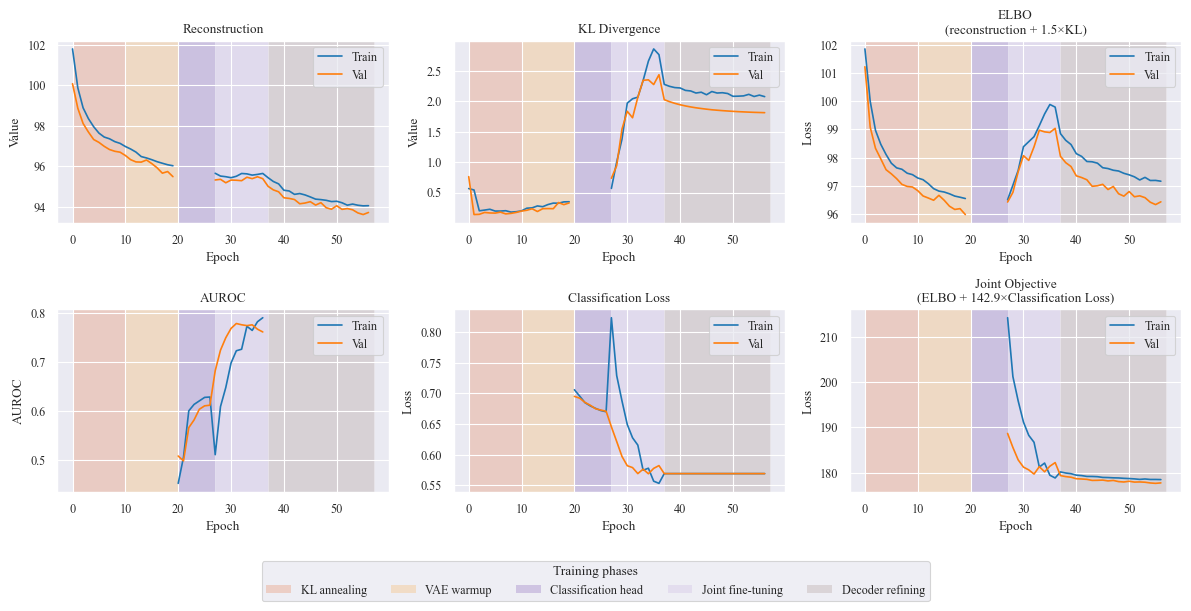

Warm-start:   0%|          | 0/20 [00:00<?, ?it/s]

Head:   0%|          | 0/7 [00:00<?, ?it/s]

Joint fine-tune:   0%|          | 0/10 [00:00<?, ?it/s]

Decoder refine:   0%|          | 0/20 [00:00<?, ?it/s]

Generating synthetic data for TSTR/TRTR comparisons…
Evaluating distrbution shift...


100%|██████████| 34/34 [18:48<00:00, 33.19s/it]


Analysis complete.
Metric table saved to E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\evaluation_metrics.csv
Calibration plot for in_hospital_mortality: E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\calibration_in_hospital_mortality.png
Latent space plot for in_hospital_mortality: E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\latent_in_hospital_mortality.png
Membership inference results saved to E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\membership_inference.csv
TSTR/TRTR comparison saved to E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\tstr_trtr_comparison_in_hospital_mortality.csv
Distribution metrics saved to E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAVE\examples\analysis_outputs_supervised\distribution_shift_metrics.csv
Summary written to E:\BaiduNetdiskWorkspace\Jupyter\my_repos\SUAV

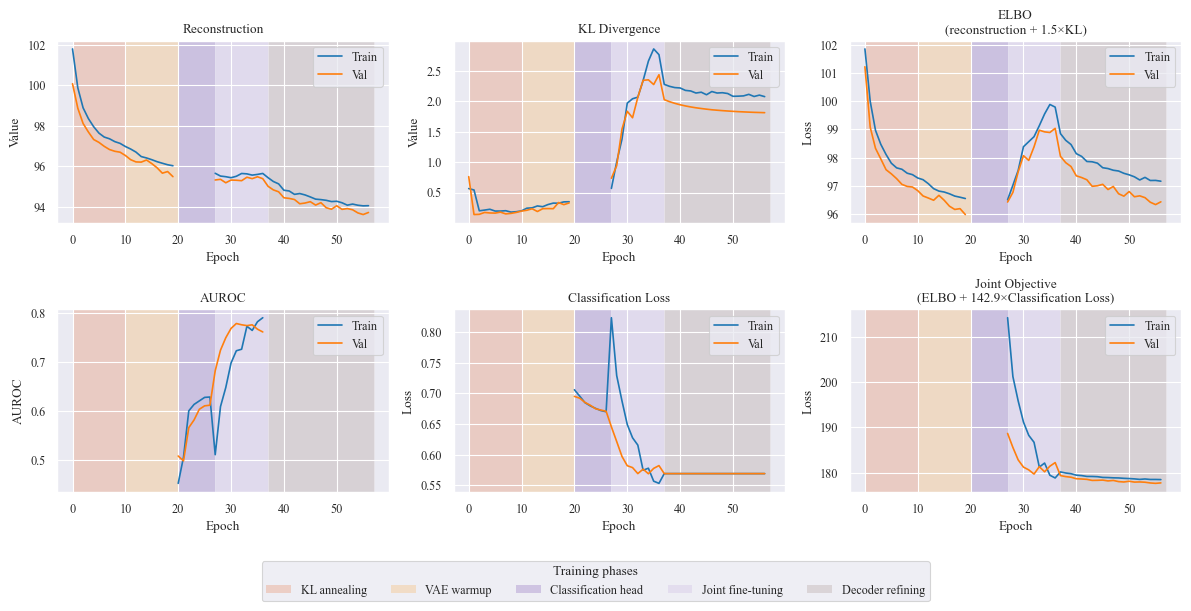

In [4]:
metrics_records: List[Dict[str, object]] = []
membership_records: List[Dict[str, object]] = []
calibration_paths: Dict[str, Path] = {}
latent_paths: Dict[str, Path] = {}

models: Dict[str, SUAVE] = {}

tstr_results: Optional[pd.DataFrame] = None
tstr_path: Optional[Path] = None
distribution_df: Optional[pd.DataFrame] = None
distribution_path: Optional[Path] = None

target = TARGET_COLUMNS[0] # can be easily extended to for loop
print(f"Training supervised model for {target}…")
X_full = prepare_features(train_df, FEATURE_COLUMNS)
y_full = train_df[target]

(
    X_train_model,
    X_validation,
    y_train_model,
    y_validation,
) = train_test_split(
    X_full,
    y_full,
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_full
)

model = SUAVE(schema=schema,behaviour="supervised")
model.fit(X_train_model, y_train_model, plot_monitor=True)
model.calibrate(X_validation, y_validation) 
models[target] = model
model.save(OUTPUT_DIR / f"suave_model_{target}.pt")

evaluation_datasets: Dict[str, Tuple[pd.DataFrame, pd.Series]] = {
    "Train": (X_train_model, y_train_model),
    "Validation": (X_validation, y_validation),
    "MIMIC test": (prepare_features(test_df, FEATURE_COLUMNS), test_df[target]),
}
if target in external_df.columns:
    evaluation_datasets["eICU external"] = (prepare_features(external_df, FEATURE_COLUMNS), external_df[target])

probability_map: Dict[str, np.ndarray] = {}
label_map: Dict[str, np.ndarray] = {}
dataset_metric_map: Dict[str, Dict[str, float]] = {}

for dataset_name, (features, labels) in evaluation_datasets.items():
    probs = model.predict_proba(features)
    probability_map[dataset_name] = probs
    label_map[dataset_name] = np.asarray(labels)
    metrics = compute_binary_metrics(probs, labels)
    dataset_metric_map[dataset_name] = metrics
    metric_row = {
        "target": target,
        "dataset": dataset_name,
        **metrics,
    }
    metrics_records.append(metric_row)

calibration_path = OUTPUT_DIR / f"calibration_{target}.png"
plot_calibration_curves(
    probability_map, label_map, target_name=target, output_path=calibration_path
)
calibration_paths[target] = calibration_path

latent_features = {
    name: features for name, (features, _) in evaluation_datasets.items()
}
latent_labels = {
    name: labels for name, (_, labels) in evaluation_datasets.items()
}
latent_path = OUTPUT_DIR / f"latent_{target}.png"
plot_latent_space(
    model,
    latent_features,
    latent_labels,
    target_name=target,
    output_path=latent_path,
)
latent_paths[target] = latent_path

train_probabilities = probability_map["Train"]
test_probabilities = probability_map["MIMIC test"]

membership = simple_membership_inference(
    train_probabilities,
    np.asarray(y_train_model),
    test_probabilities,
    np.asarray(evaluation_datasets["MIMIC test"][1]),
)
membership_records.append({"target": target, **membership})

metrics_df = pd.DataFrame(metrics_records)
metrics_path = OUTPUT_DIR / "evaluation_metrics.csv"
metrics_df.to_csv(metrics_path, index=False)

membership_df = pd.DataFrame(membership_records)
membership_path = OUTPUT_DIR / "membership_inference.csv"
membership_df.to_csv(membership_path, index=False)

in_hospital_model = models.get("in_hospital_mortality")
if in_hospital_model is not None:
    print("Generating synthetic data for TSTR/TRTR comparisons…")
    X_train_full = prepare_features(train_df, FEATURE_COLUMNS)
    y_train_full = train_df["in_hospital_mortality"]
    numeric_train = to_numeric_frame(X_train_full)

    rng = np.random.default_rng(RANDOM_STATE)
    synthetic_labels = rng.choice(
        y_train_full, size=len(y_train_full), replace=True
    )

    synthetic_features = in_hospital_model.sample(
        len(synthetic_labels), conditional=True, y=synthetic_labels
    )
    numeric_synthetic = to_numeric_frame(synthetic_features[FEATURE_COLUMNS])

    numeric_test = to_numeric_frame(prepare_features(test_df, FEATURE_COLUMNS))
    y_test = test_df["in_hospital_mortality"]

    tstr_metrics = evaluate_tstr(
        (numeric_synthetic.to_numpy(), np.asarray(synthetic_labels)),
        (numeric_test.to_numpy(), y_test.to_numpy()),
        make_logistic_pipeline,
    )
    trtr_metrics = evaluate_trtr(
        (numeric_train.to_numpy(), y_train_full.to_numpy()),
        (numeric_test.to_numpy(), y_test.to_numpy()),
        make_logistic_pipeline,
    )
    tstr_results = pd.DataFrame(
        [
            {"setting": "TSTR", **tstr_metrics},
            {"setting": "TRTR", **trtr_metrics},
        ]
    )
    tstr_path = OUTPUT_DIR / f"tstr_trtr_comparison_{target}.csv"
    tstr_results.to_csv(tstr_path, index=False)

    print(f'Evaluating distrbution shift...')
    distribution_rows: List[Dict[str, object]] = []
    for column in tqdm(FEATURE_COLUMNS):
        real_values = numeric_train[column].to_numpy()
        synthetic_values = numeric_synthetic[column].to_numpy()
        mmd_value, mmd_p = rbf_mmd(
            real_values, synthetic_values, random_state=RANDOM_STATE, 
            n_permutations=100, #! super time consuming, set ~3000 to get stable p-vals
        )
        distribution_rows.append(
            {
                "feature": column,
                "ks": kolmogorov_smirnov_statistic(real_values, synthetic_values),
                "mmd": mmd_value,
                "mmd_p_value": mmd_p,
                "mutual_information": mutual_information_feature(
                    real_values, synthetic_values
                ),
            }
        )
    distribution_path = OUTPUT_DIR / "distribution_shift_metrics.csv"
    distribution_df = pd.DataFrame(distribution_rows)
    distribution_df.to_csv(distribution_path, index=False)
else:
    print("Primary target model not available; skipping TSTR/TRTR and distribution analysis.")


summary_lines: List[str] = [
    "# Mortality modelling report",
    "",
    "## Schema",
    schema_table,
    "",
    "## Model selection and performance",
]

if tstr_results is not None:
    summary_lines.append("## TSTR vs TRTR")
    summary_lines.append("| Setting | Accuracy | AUROC | AUPRC | Brier | ECE |")
    summary_lines.append("| --- | --- | --- | --- | --- | --- |")
    for _, row in tstr_results.iterrows():
        summary_lines.append(
            "| {setting} | {acc:.3f} | {auroc:.3f} | {auprc:.3f} | {brier:.3f} | {ece:.3f} |".format(
                setting=row["setting"],
                acc=row.get("accuracy", np.nan),
                auroc=row.get("auroc", row.get("auc", np.nan)),
                auprc=row.get("auprc", np.nan),
                brier=row.get("brier", np.nan),
                ece=row.get("ece", np.nan),
            )
        )
    summary_lines.append("")

summary_lines.append("## Distribution shift and privacy")
if distribution_df is not None and distribution_path is not None:
    distribution_top = distribution_df.sort_values("ks", ascending=False).head(10)
    summary_lines.append("Top 10 features by KS statistic:")
    summary_lines.append("| Feature | KS | MMD | Mutual information |")
    summary_lines.append("| --- | --- | --- | --- |")
    for _, row in distribution_top.iterrows():
        summary_lines.append(
            "| {feature} | {ks:.3f} | {mmd:.3f} | {mi:.3f} |".format(
                feature=row["feature"],
                ks=row.get("ks", np.nan),
                mmd=row.get("mmd", np.nan),
                mi=row.get("mutual_information", np.nan),
            )
        )
    summary_lines.append(
        f"Full distribution metrics: {distribution_path.relative_to(OUTPUT_DIR)}"
    )
else:
    summary_lines.append("Distribution metrics were not computed.")

if membership_df.empty:
    summary_lines.append("No membership inference metrics were recorded.")
else:
    summary_lines.append("Membership inference results:")
    summary_lines.append(
        "| Target | Attack AUC | Best accuracy | Threshold | Majority baseline |"
    )
    summary_lines.append("| --- | --- | --- | --- | --- |")
    for _, row in membership_df.iterrows():
        summary_lines.append(
            "| {target} | {auc:.3f} | {best_acc:.3f} | {threshold:.3f} | {majority:.3f} |".format(
                target=row["target"],
                auc=row.get("attack_auc", np.nan),
                best_acc=row.get("attack_best_accuracy", np.nan),
                threshold=row.get("attack_best_threshold", np.nan),
                majority=row.get("attack_majority_class_accuracy", np.nan),
            )
        )
    summary_lines.append(
        f"Membership metrics saved to: {membership_path.relative_to(OUTPUT_DIR)}"
    )

summary_path = OUTPUT_DIR / "summary.md"
summary_path.write_text("\n".join(summary_lines), encoding="utf-8")

print("Analysis complete.")
print(f"Metric table saved to {metrics_path}")
for target, path in calibration_paths.items():
    print(f"Calibration plot for {target}: {path}")
for target, path in latent_paths.items():
    print(f"Latent space plot for {target}: {path}")
print(f"Membership inference results saved to {membership_path}")
if (
    in_hospital_model is not None
    and tstr_path is not None
    and distribution_path is not None
):
    print(f"TSTR/TRTR comparison saved to {tstr_path}")
    print(f"Distribution metrics saved to {distribution_path}")
print(f"Summary written to {summary_path}")
